# Poisson Process in Software Performance Engineering
## Hands-on Lecture

**Learning Objectives:**
- Implement a Poisson workload generator
- Validate statistical properties of the process
- Verify match with M/M/1 formulas through practical experiments

---

## Module 1: Review and Workload Generator

### 1.0 Poisson Process - Formal Definition

**Definition via Transition Probabilities**: A counting process $\{N(t), t \geq 0\}$ is a Poisson process with intensity $\lambda > 0$ if:

1. **Initial condition**: $N(0) = 0$

2. **Transition probabilities**: For any time interval $\tau > 0$, the probability of exactly $k$ events occurring is:

   $$P(N(t+\tau) - N(t) = k) = \frac{e^{-\lambda\tau} \cdot (\lambda\tau)^k}{k!}$$

   where $k = 0, 1, 2, \ldots$

**Key Properties:**
- **Stationary increments**: Probability depends only on interval length $\tau$, not on absolute time $t$
- **Independent increments**: Non-overlapping intervals are independent
- **Intensity $\lambda$**: Expected number of events per unit time
- **Memoryless**: Past events don't influence future probabilities

In [7]:

# Import required librarie
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
import time
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Poisson Process Transition Probabilities
Intensity λ = 3 events/second
Time interval τ = 2 seconds
Expected events in τ: λτ = 6


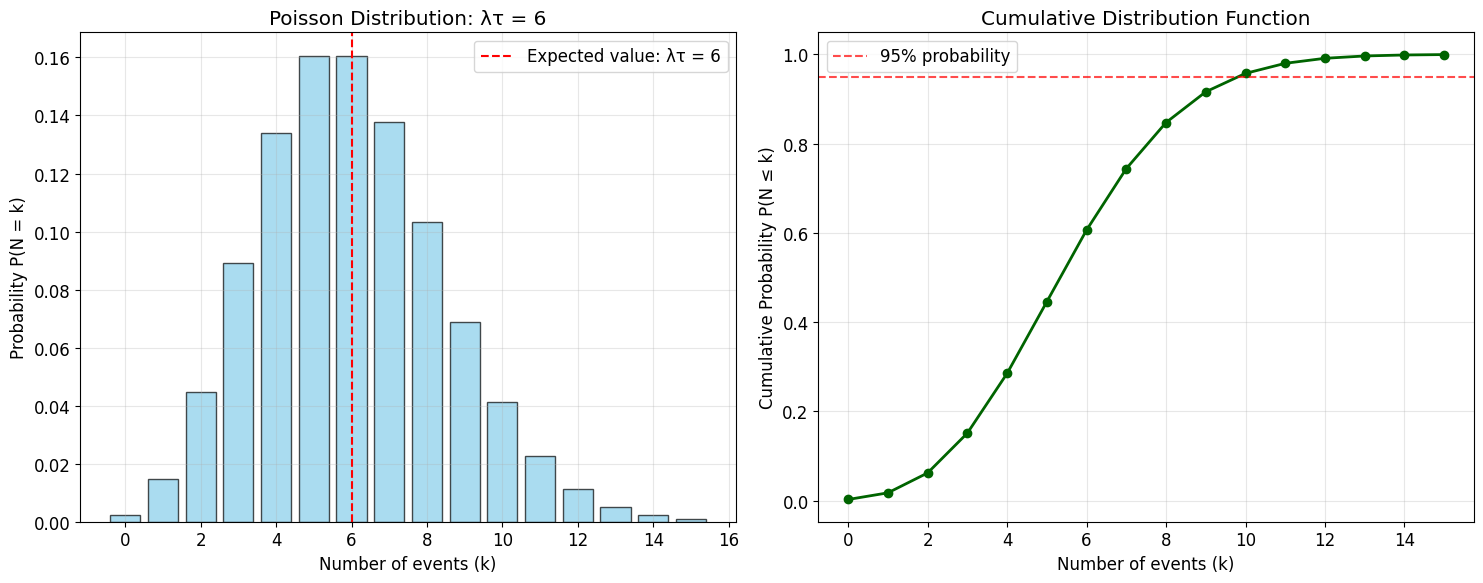


Key Statistics:
Sum of probabilities: 0.999491
Most likely outcome: 5 events
P(exactly 6 events): 0.1606
P(≤ 6 events): 0.6063

Most Significant Probabilities:
-----------------------------------
P(k =  1) = 0.0149 (1.5%)
P(k =  2) = 0.0446 (4.5%)
P(k =  3) = 0.0892 (8.9%)
P(k =  4) = 0.1339 (13.4%)
P(k =  5) = 0.1606 (16.1%)
P(k =  6) = 0.1606 (16.1%)
P(k =  7) = 0.1377 (13.8%)
P(k =  8) = 0.1033 (10.3%)
P(k =  9) = 0.0688 (6.9%)
P(k = 10) = 0.0413 (4.1%)
P(k = 11) = 0.0225 (2.3%)
P(k = 12) = 0.0113 (1.1%)


In [ ]:
# Practical example of transition probabilities
lambda_rate = 3  # requests per second
tau = 2  # time interval in seconds

print("Poisson Process Transition Probabilities")
print("="*45)
print(f"Intensity λ = {lambda_rate} events/second")
print(f"Time interval τ = {tau} seconds")
print(f"Expected events in τ: λτ = {lambda_rate * tau}")

# Calculate probabilities for k = 0, 1, 2, ..., 15
import math
k_values = range(20)
probabilities = []

for k in k_values:
    # P(N(t+τ) - N(t) = k) = e^(-λτ) * (λτ)^k / k!
    prob = math.exp(-lambda_rate * tau) * (lambda_rate * tau)**k / math.factorial(k)
    probabilities.append(prob)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of probabilities
axes[0].bar(k_values, probabilities, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(lambda_rate * tau, color='red', linestyle='--', 
                label=f'Expected value: λτ = {lambda_rate * tau}')
axes[0].set_xlabel('Number of events (k)')
axes[0].set_ylabel('Probability P(N = k)')
axes[0].set_title(f'Poisson Distribution: λτ = {lambda_rate * tau}')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Cumulative distribution
cumulative_prob = np.cumsum(probabilities)
axes[1].plot(k_values, cumulative_prob, 'o-', color='darkgreen', linewidth=2)
axes[1].axhline(0.95, color='red', linestyle='--', alpha=0.7, label='95% probability')
axes[1].set_xlabel('Number of events (k)')
axes[1].set_ylabel('Cumulative Probability P(N ≤ k)')
axes[1].set_title('Cumulative Distribution Function')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Print key statistics
print(f"\nKey Statistics:")
print(f"Sum of probabilities: {sum(probabilities):.6f}")
print(f"Most likely outcome: {k_values[np.argmax(probabilities)]} events")
print(f"P(exactly {lambda_rate * tau} events): {probabilities[lambda_rate * tau]:.4f}")
print(f"P(≤ {lambda_rate * tau} events): {cumulative_prob[lambda_rate * tau]:.4f}")

# Show only the most significant probabilities in table format
print(f"\nMost Significant Probabilities:")
print("-" * 35)
for k, prob in enumerate(probabilities):
    if prob > 0.01:  # Show only probabilities > 1%
        print(f"P(k = {k:2d}) = {prob:.4f} ({prob*100:.1f}%)")

### 1.1 Parameter λ and Practical Meaning

The parameter **λ** (lambda) represents the **rate** or **intensity** of the process:
- λ = 5 means "5 events per unit time on average"
- In SPE context: "5 requests per second on average"
- Higher λ = more intense workload

In [ ]:
# Visualize different λ values
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
lambda_values = [1, 5, 10]
time_window = 10

for i, lam in enumerate(lambda_values):
    # Generate multiple realizations
    samples = [np.random.poisson(lam * time_window) for _ in range(1000)]
    
    axes[i].hist(samples, bins=range(max(samples)+2), density=True, 
                alpha=0.7, edgecolor='black')
    axes[i].axvline(lam * time_window, color='red', linestyle='--', 
                   label=f'Expected: {lam * time_window}')
    axes[i].set_title(f'λ = {lam} req/s')
    axes[i].set_xlabel('Arrivals in 10s')
    axes[i].set_ylabel('Probability')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Effect of λ on Arrival Distribution')
plt.tight_layout()
plt.show()

print("Key Observation: Higher λ means:")
print("- More arrivals on average")
print("- Higher variability (wider distribution)")
print("- More intense workload for the system")

### 1.2 Exponential Inter-arrival Times

**Key Property**: If arrivals follow a Poisson process with rate λ, then the time between consecutive arrivals follows an **Exponential(λ)** distribution.

**Practical meaning**:
- Most requests arrive close together
- Few requests have large gaps between them
- Memoryless: knowing when the last request arrived doesn't help predict the next one

In [ ]:
# Generate and visualize inter-arrival times
lambda_rate = 5  # requests per second
n_samples = 5000

# Generate inter-arrival times
inter_arrivals = np.random.exponential(1/lambda_rate, n_samples)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of inter-arrival times
axes[0].hist(inter_arrivals, bins=50, density=True, alpha=0.7, 
            label='Simulated', edgecolor='black')

# Overlay theoretical exponential PDF
x = np.linspace(0, 2, 200)
theoretical_pdf = lambda_rate * np.exp(-lambda_rate * x)
axes[0].plot(x, theoretical_pdf, 'r-', linewidth=2, label='Theoretical Exp(λ)')
axes[0].set_xlabel('Inter-arrival Time (seconds)')
axes[0].set_ylabel('Density')
axes[0].set_title('Inter-arrival Times Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series of first 50 arrivals
arrival_times = np.cumsum(inter_arrivals[:50])
axes[1].scatter(arrival_times, range(1, 51), alpha=0.7, s=50)
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Arrival Number')
axes[1].set_title('First 50 Arrival Times')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical validation
expected_mean = 1/lambda_rate
observed_mean = np.mean(inter_arrivals)
expected_std = 1/lambda_rate
observed_std = np.std(inter_arrivals)

print("Statistical Validation:")
print("="*30)
print(f"Expected mean: {expected_mean:.3f}s")
print(f"Observed mean: {observed_mean:.3f}s")
print(f"Expected std:  {expected_std:.3f}s")
print(f"Observed std:  {observed_std:.3f}s")
print(f"\nGoodness of fit (Kolmogorov-Smirnov test):")
ks_stat, ks_pvalue = stats.kstest(inter_arrivals, lambda x: stats.expon.cdf(x, scale=1/lambda_rate))
print(f"KS statistic: {ks_stat:.4f}")
print(f"p-value: {ks_pvalue:.4f}")
print(f"Result: {'PASS' if ks_pvalue > 0.05 else 'FAIL'} (α=0.05)")

### 1.3 Connection with M/M/1 Systems

**M/M/1 Queue**:
- **First M**: Markovian (Poisson) arrivals with rate λ
- **Second M**: Markovian (Exponential) service times with rate μ
- **1**: Single server

**Key Formulas** (we'll validate these experimentally):
- **Utilization**: ρ = λ/μ (must be < 1 for stability)
- **Expected response time**: E[T] = 1/(μ-λ)
- **Expected number in system**: E[N] = ρ/(1-ρ)
- **Expected queue length**: E[Nq] = ρ²/(1-ρ)

In [ ]:
# M/M/1 theoretical predictions
lambda_rate = 5  # arrivals per second
mu_rate = 8      # service rate (requests per second)

# Check stability condition
rho = lambda_rate / mu_rate
print("M/M/1 System Parameters:")
print("="*30)
print(f"Arrival rate (λ): {lambda_rate} req/s")
print(f"Service rate (μ): {mu_rate} req/s")
print(f"Utilization (ρ):  {rho:.3f}")

if rho >= 1:
    print("⚠️  WARNING: System is unstable (ρ ≥ 1)!")
else:
    print("✅ System is stable (ρ < 1)")

# Calculate theoretical metrics
E_T = 1 / (mu_rate - lambda_rate)  # Expected response time
E_N = rho / (1 - rho)              # Expected number in system
E_Nq = (rho**2) / (1 - rho)        # Expected queue length
E_W = lambda_rate / (mu_rate * (mu_rate - lambda_rate))  # Expected waiting time

print("\nTheoretical Performance Metrics:")
print("="*35)
print(f"Expected response time: {E_T:.3f} seconds")
print(f"Expected number in system: {E_N:.3f}")
print(f"Expected queue length: {E_Nq:.3f}")
print(f"Expected waiting time: {E_W:.3f} seconds")

print("\n🎯 Goal: We'll validate these predictions using our Poisson generator!")

In [ ]:
# Visualize how utilization affects performance
lambda_values = np.linspace(0.1, 7.9, 100)
mu = 8

rho_values = lambda_values / mu
E_T_values = 1 / (mu - lambda_values)
E_N_values = rho_values / (1 - rho_values)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Response time vs utilization
axes[0].plot(rho_values, E_T_values, 'b-', linewidth=2)
axes[0].axvline(rho, color='red', linestyle='--', 
               label=f'Our system (ρ={rho:.2f})')
axes[0].axhline(E_T, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Utilization (ρ)')
axes[0].set_ylabel('Expected Response Time')
axes[0].set_title('Response Time vs Utilization')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_ylim(0, 2)

# Number in system vs utilization
axes[1].plot(rho_values, E_N_values, 'g-', linewidth=2)
axes[1].axvline(rho, color='red', linestyle='--', 
               label=f'Our system (ρ={rho:.2f})')
axes[1].axhline(E_N, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Utilization (ρ)')
axes[1].set_ylabel('Expected Number in System')
axes[1].set_title('Queue Length vs Utilization')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim(0, 20)

plt.tight_layout()
plt.show()

print("Key Insights:")
print("- As ρ → 1, response time → ∞")
print("- Small increases in λ can dramatically increase delays")
print("- System becomes very sensitive near capacity")

---
## Summary of Module 1 Review

**What we've established:**
1. **Poisson process**: Formal definition and key properties
2. **Parameter λ**: Controls workload intensity
3. **Inter-arrival times**: Follow exponential distribution
4. **M/M/1 connection**: Theoretical formulas to validate

**Next steps:**
- Implement robust Poisson workload generator
- Validate statistical properties experimentally
- Apply to M/M/1 system and verify theoretical predictions

---